# Assignment 1

Jonathan McEntee - September 9th 2018

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

## Abalone Data Set

In [ ]:
abalone_data = pd.read_csv('abalone.csv')

In [ ]:
def convert_to_age_categories(num_rings):
    if num_rings < 9:
        return "Young"
    elif num_rings < 11:
        return "Middle-Aged"
    else:
        return "Old"
    
age_categories = abalone_data.rings.apply(convert_to_age_categories)
abalone_data = abalone_data.assign(age_category = age_categories)
abalone_data.head()

In [ ]:
sns.set(style='ticks')
data_to_pairplot = abalone_data.drop(['rings', 'shucked_weight'], axis=1)
sns.pairplot(data_to_pairplot, hue='age_category')

In [ ]:
abalone_data.age_category.value_counts()

Lets make a training and a test set

In [ ]:
abalone_data = abalone_data.assign(**pd.get_dummies(abalone_data.sex)).drop(['sex', 'rings'], axis=1)

In [ ]:
y = abalone_data['age_category']
X = abalone_data.drop(['age_category'], axis=1)

## Blood Transfusion Data Set

In [2]:
blood_data = pd.read_csv('transfusions.csv')
blood_data["donated_blood"] = blood_data.donated_blood.apply(lambda x : 'Yes' if x is 1 else 'No')

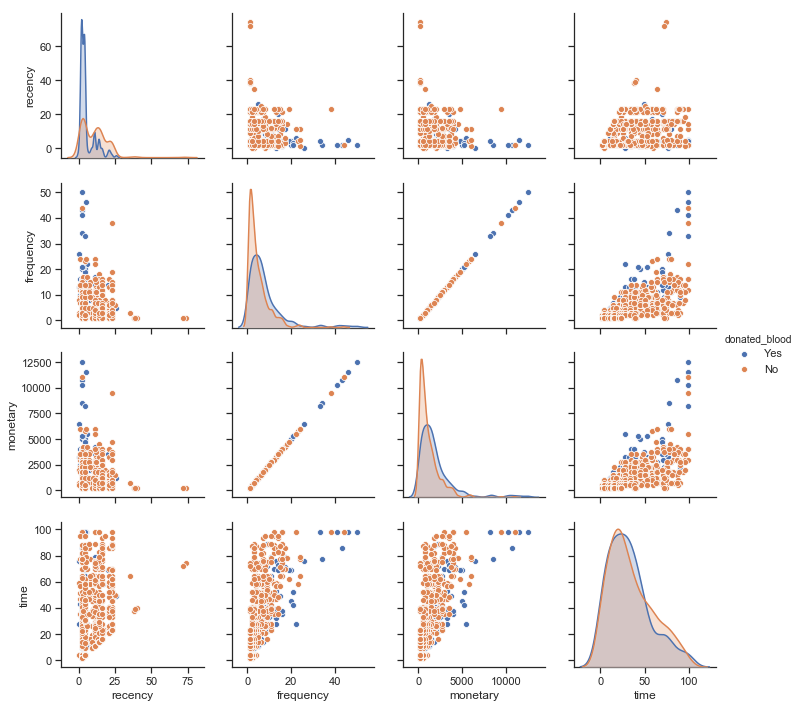

In [15]:
sns.set(style='ticks')
sns.pairplot(blood_data, hue='donated_blood')

In [10]:
y = blood_data["donated_blood"]
X = blood_data.drop(["donated_blood"], axis=1)

## Create Test and Training Sets

In [20]:
y_train, y_test = train_test_split(y, test_size=0.2, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.2, stratify=y, random_state=42)

## Functions

In [21]:
def learning_curve_dataframe(X_train, X_test, y_train, y_test, clf):
    score_type = []
    scores = []
    no_samples = []

    for test_size in np.arange(0.05, 0.95, 0.01):
        X_cv_train, X_cv_test = train_test_split(X_train, test_size=test_size, random_state=42)
        y_cv_train, y_cv_test = train_test_split(y_train, test_size=test_size, random_state=42)

        clf.fit(X=X_cv_train, y=y_cv_train)

        for _ in range(2): no_samples.append(len(X_cv_train))

        score_type.append('training')
        scores.append(clf.score(X=X_cv_train, y=y_cv_train))

        score_type.append('test')
        scores.append(clf.score(X=X_test, y=y_test))

    return pd.DataFrame(dict(no_samples=no_samples, score=scores, score_type=score_type))
    
def feature_growth_data(clf, X, y, variable, parameter_range):
    """ Compares training and cross-validation accuracy over a changing hyperparameter.
    
    Parameters:
        clf: the classifier
        fixed: a dictionary of fixed parameters
        variable: a string naming the parameter to be varied
        parameter_range: the values (generally a numeric range) to vary over
    """
    no_samples = []
    scores = []
    score_type = []

    for parameter_value in parameter_range:
        parameter = {variable : parameter_value}
        clf = clf.set_params(**parameter)
        clf.fit(X=X, y=y)

        for _ in range(2): no_samples.append(parameter_value)

        score_type.append('training')
        scores.append(clf.score(X=X, y=y))

        score_type.append('cross validation')
        scores.append(cross_val_score(clf, X=X, y=y, cv=10).mean())
        
    return pd.DataFrame(dict(no_samples=no_samples, score=scores, score_type=score_type))

def plot_scores(title, score_data, xlabel=None, ylabel=None):
    fig = plt.figure()
    fig.suptitle(title)
    
    sns.set_style("whitegrid")
    plt.ylim(ymin=0)
    curves = sns.lineplot(x='no_samples', y='score', hue='score_type', data=score_data)
    
    if xlabel is not None:
        curves.set(xlabel=xlabel)
    
    if ylabel is not None:
        curves.set(ylabel=ylabel)
    
    sns.despine(left=True)

## Using a Decision Tree Classifier

First we'll find the best parameters with a grid search

In [ ]:
parameters = {
    'max_depth' : list(range(1, 30, 2)),
    'min_samples_split' : list(range(20, 1000, 10))
}

decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

The best parameters appear to be min_samples_split=400 and max_depth=7

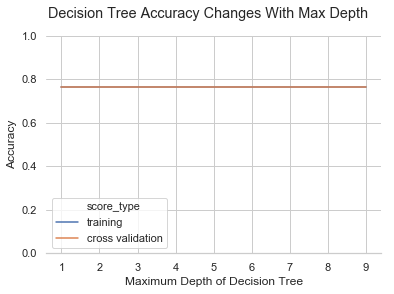

In [22]:
decision_tree = DecisionTreeClassifier(min_samples_split=420)
accuracy_vs_depth = feature_growth_data(clf=decision_tree, X=X_train, y=y_train,
                                        variable='max_depth', parameter_range=range(1, 10))

plot_scores(title="Decision Tree Accuracy Changes With Max Depth",
            xlabel="Maximum Depth of Decision Tree",
            ylabel="Accuracy",
            score_data=accuracy_vs_depth)

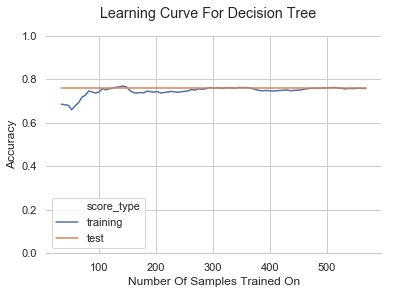

In [23]:
clf = DecisionTreeClassifier(max_depth=7, min_samples_split=400)
learning_curve_data = learning_curve_dataframe(X_train, X_test, y_train, y_test, clf=clf)

plot_scores(title="Learning Curve For Decision Tree",
            xlabel="Number Of Samples Trained On",
            ylabel="Accuracy",
            score_data = learning_curve_data)

## Using K Nearest Neighbors

In [ ]:
parameters = {
    'n_neighbors' : list(range(1, 30)),
    'weights' : ['uniform', 'distance'],
    "p" : [1, 2]
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

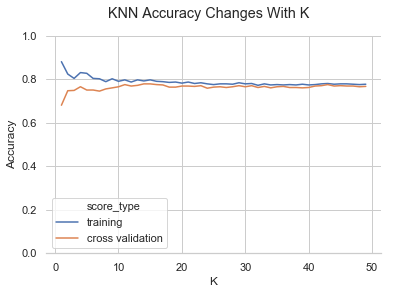

In [24]:
clf = KNeighborsClassifier(p=2)
accuracy_vs_depth = feature_growth_data(clf=clf, X=X_train, y=y_train,
                                        variable='n_neighbors', parameter_range=range(1, 50))

plot_scores(title="KNN Accuracy Changes With K",
            xlabel="K",
            ylabel="Accuracy",
            score_data=accuracy_vs_depth)

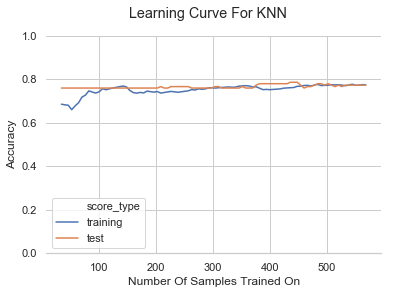

In [25]:
clf = KNeighborsClassifier(p=2, n_neighbors=30)
learning_curve_data = learning_curve_dataframe(X_train, X_test, y_train, y_test, clf=clf)

plot_scores(title="Learning Curve For KNN",
            xlabel="Number Of Samples Trained On",
            ylabel="Accuracy",
            score_data = learning_curve_data)

## Using AdaBoost

In [ ]:
parameters = {
    'n_estimators' : list(range(20, 80)),
    'learning_rate' : [10**x for x in range(-1, 2)],
}

ada_booster = AdaBoostClassifier()
clf = GridSearchCV(ada_booster, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

learning rate = 1, n_estimators = 40

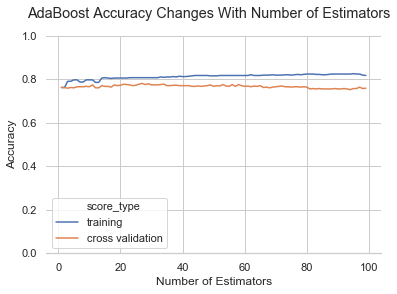

In [26]:
clf = AdaBoostClassifier(learning_rate=1)
accuracy_vs_depth = feature_growth_data(clf=clf, X=X_train, y=y_train,
                                        variable='n_estimators', parameter_range=range(1, 100))

plot_scores(title="AdaBoost Accuracy Changes With Number of Estimators",
            xlabel="Number of Estimators",
            ylabel="Accuracy",
            score_data=accuracy_vs_depth)

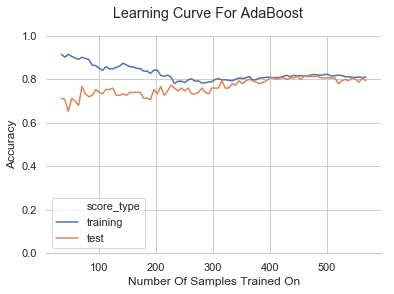

In [27]:
clf = AdaBoostClassifier(learning_rate=1, n_estimators=40)
learning_curve_data = learning_curve_dataframe(X_train, X_test, y_train, y_test, clf=clf)

plot_scores(title="Learning Curve For AdaBoost",
            xlabel="Number Of Samples Trained On",
            ylabel="Accuracy",
            score_data = learning_curve_data)

## Using a Neural Net

In [ ]:
parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)],
}

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

Best hidden layer size = 3 rows of 50 (50, 50, 50)

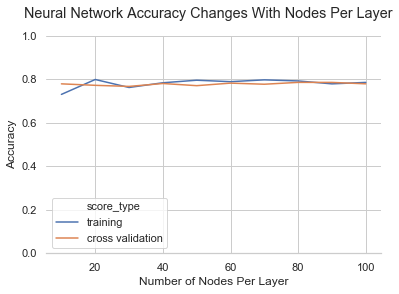

In [28]:
clf = MLPClassifier()
accuracy_vs_depth = feature_growth_data(clf=clf, X=X_train, y=y_train,
                                        variable='hidden_layer_sizes',
                                        parameter_range=[tuple([x] * 3) for x in range(10, 101, 10)])
accuracy_vs_depth["no_samples"] = accuracy_vs_depth.no_samples.apply(lambda x: x[0])

plot_scores(title="Neural Network Accuracy Changes With Nodes Per Layer",
            xlabel="Number of Nodes Per Layer",
            ylabel="Accuracy",
            score_data=accuracy_vs_depth)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


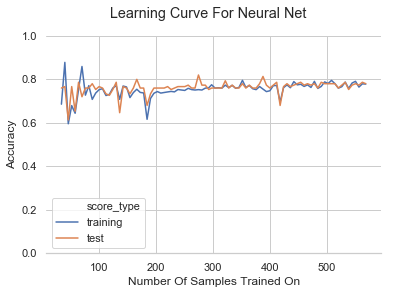

In [29]:
clf = MLPClassifier(hidden_layer_sizes=(40,40,40))
learning_curve_data = learning_curve_dataframe(X_train, X_test, y_train, y_test, clf=clf)

plot_scores(title="Learning Curve For Neural Net",
            xlabel="Number Of Samples Trained On",
            ylabel="Accuracy",
            score_data = learning_curve_data)

## Using a Linear Support Vector Machine

In [ ]:
parameters = [{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['poly'],
    'degree' : range(1,10)
},
{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['rbf'],
    'gamma': [1e-3, 1e-4]
},
{
    'C' : [1, 10, 100, 1000],
    'kernel' : ['linear']
}
]

parameters = {
    'C' : [1, 10, 100, 1000],
}

lsvc = LinearSVC()
clf = GridSearchCV(lsvc, parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
clf = SVC(C=1000, kernel='poly')
accuracy_vs_depth = feature_growth_data(clf=clf, X=X_train, y=y_train,
                                        variable='degree',
                                        parameter_range=range(1,10))

plot_scores(title="Poly SVM Accuracy Changes With Polynomial Coefficient",
            xlabel="Degree",
            ylabel="Accuracy",
            score_data=accuracy_vs_depth)

In [ ]:
poly = SVC(C=1000, kernel='poly', degree=2)
rbf = SVC(C=1000, gamma=0.001)
linear = LinearSVC(C=10)

for model in (poly, rbf, linear):
    model.fit(X=X_train, y=y_train)

In [ ]:
svm_scores = pd.DataFrame({
    "kernel" : ['polynomial', 'linear', 'rbf'],
    "training score" : [poly.score(X_train, y_train),
                        linear.score(X_train, y_train),
                        rbf.score(X_train, y_train)],
    "cross validation score" : [cross_val_score(poly, X=X_train, y=y_train, cv=10).mean(),
                                cross_val_score(linear, X=X_train, y=y_train, cv=10).mean(),
                                cross_val_score(rbf, X=X_train, y=y_train, cv=10).mean()]
})

In [ ]:
svm_scores